# Dyad-level predictions

This notebook approaches the final prediction problem: how many refugees will flow at the country-dyad level the following year. It learns from the lessons of optimizing the outflow problem, using the preprocessing that was most successful then.

Similarly as with the outflow problem, we add variables by stages and compare the results to find the best performing model.

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import model_helpers
import matplotlib.pyplot as plt

from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

## Load Data
UNHCR

In [2]:
def load_unhcr():
    df = pd.read_csv('../../data/clean/unhcr.csv', engine='pyarrow').sort_values(by=['year']).query('year <= 2021').reset_index(drop=True).drop(['Country_o','Country_d'], axis=1)

    # get continent
    df['continent_o'] = df[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent))
    df['continent_d'] = df[['iso_d']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent))

    # calculate outflow and inflow
    df = df.merge(df.groupby(['iso_o','year']).newarrival.sum().rename('outflow'), how='left',left_on=['iso_o','year'], right_index=True)
    df = df.merge(df.groupby(['iso_d','year']).newarrival.sum().rename('inflow'), how='left',left_on=['iso_d','year'], right_index=True)
    
    # generate shift variables
    shift_cols_3 = ['outflow','newarrival','dead_o', 'best_est_o', "dead_log_o"]
    # shift_cols_2 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]
    # shifted_df_filled_2 = model_helpers.multi_shift_ffill(df, shift_cols_2, range(1, 3), 'iso_o', 'year')
    shifted_df_filled_3 = model_helpers.multi_shift_ffill(df, shift_cols_3, range(1, 4), 'Id', 'year')
    # data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_2.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
    df = pd.concat([df, shifted_df_filled_3.reset_index(drop=True).drop(columns=["Id", "year"])], axis=1)

    # generate rolling variables
    window_sizes  = [4, 6, 11]
    group_col = ['Id']
    value_cols = ['outflow', 'best_est_o', 'newarrival','inflow']

    df = model_helpers.generate_rolling_sum_variables(df, group_col, value_cols, window_sizes, date_col='year')

    return df

In [50]:
unhcr.to_csv('../../data/clean/aggregated_engineered/unhcr.csv')

In [3]:
unhcr = load_unhcr()

In [3]:
unhcr = pd.read_csv('../../data/clean/aggregated_engineered/unhcr.csv', engine='pyarrow')

Trends

In [9]:
import country_converter as coco

def country_to_iso3(long):
    return coco.convert(long, to='iso3')

def process_trends_df(df):
    df[['iso_o','iso_d']] = df[['country_o','topic_title']].apply(lambda x: model_helpers.mapper(x, country_to_iso3))
    df.drop(['country_o','topic_title'], axis=1, inplace=True)
    df.groupby(['iso_o','iso_d']).apply(lambda x: x.apply(model_helpers.smooth_spikes)).reset_index(drop=True)
    val_col = df.columns[~df.columns.isin(['iso_o', 'iso_d', 'date'])][0]
    df = df.groupby(['iso_o', 'iso_d', 'date']).agg({val_col:{'mean','max'}}).reset_index()
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

def load_trends():
    path = '../trends/data/2005_topics/'

    ## countries ##
    countries_trends = pd.read_csv(path + 'country_topic_trends_2005_complete.csv', engine='pyarrow')
    countries_trends_2 = pd.read_csv(path + 'country_topic_trends_2005_order2.csv', engine='pyarrow')
    countries_trends_3 = pd.read_csv(path + 'country_topic_trends_2005_top_remaining.csv', engine='pyarrow')

    countries_trends = pd.concat([countries_trends, countries_trends_2, countries_trends_3], axis=0).rename({'value':'country_trend'}, axis=1)
    country_topic_ids = pd.read_csv('../trends/topic_ids/country_topic_ids.csv')[['topic_mid','topic_title']]
    countries_trends = countries_trends.merge(country_topic_ids).drop('topic_mid', axis=1).dropna().drop_duplicates()

    countries_trends = process_trends_df(countries_trends)

    ## cities ##
    cities = pd.read_csv(path + 'cities_topic_trends_2005_order1.csv', engine='pyarrow')
    cities_2 = pd.read_csv(path + 'cities_topic_trends_2005_order2.csv', engine='pyarrow')
    cities_3 = pd.read_csv(path + 'cities_topic_trends_2005_top_remaining.csv', engine='pyarrow')
    # cities_4 = pd.read_csv('../trends/data/2005_topics/bordering_cities_trends.csv', engine='pyarrow').rename({'':'date', 'country_d':'search_country'}, axis=1).melt(id_vars=['date','search_country','country_o'],value_name='value')

    cities = pd.concat([cities,cities_2,cities_3], axis=0).rename({'value':'city_trend'}, axis=1).dropna().drop_duplicates()

    city_topic_ids = pd.read_csv('../trends/topic_ids/city_topic_id.csv')
    cities = cities.merge(city_topic_ids, how='left', on='topic_mid').drop(['topic_mid','search_keyword','topic_type','topic_title'], axis=1).dropna().rename({'search_country':'topic_title'}, axis=1)
    cities['city_trend'] = cities.city_trend.astype(int)
    
    cities = process_trends_df(cities)

    ## visa ##
    visatrend = pd.read_csv("../trends/trends_downloads/interactions_full/interactions visa.csv", engine='pyarrow')

    visatrend["name"] = visatrend['keyword_en'].str.split(' ', expand=True)[1]
    names = visatrend["name"].unique()
    df = pd.DataFrame(names, columns=["name"])
    df = df[df["name"].isnull()==False]
    df["iso_d"] = df["name"].apply(model_helpers.name_to_iso3)
    visatrend = pd.merge(visatrend, df, on="name", how="left").rename({'trends_index':'visa_trend'}, axis=1)

    visatrend['iso_o'] = visatrend[['region']].apply(lambda x: model_helpers.mapper(x, country_to_iso3))
    visatrend = visatrend.groupby(['iso_o','iso_d']).apply(lambda x: x.apply(model_helpers.smooth_spikes)).reset_index(drop=True)
    visatrend = visatrend.groupby(['iso_o', 'iso_d', 'date']).agg({'visa_trend':{'mean','max'}}).reset_index()
    visatrend.columns = [' '.join(col).strip() for col in visatrend.columns.values]

    ## semantic topics ##
    topics = pd.read_csv("../trends/data/2005_topics/semantic_topic_trends_2005_complete.csv", engine='pyarrow').drop(columns=[""]).drop_duplicates()
    topics['iso_o'] = topics.country.map(dict(zip(topics.country.unique(), country_to_iso3(topics.country.unique()))))
    topics.drop('country',axis=1, inplace=True)
    topics = topics.groupby(['iso_o']).apply(lambda x: x.apply(model_helpers.smooth_spikes)).reset_index(drop=True)
    
    ## weight by internet and pop ## 
    internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv", engine='pyarrow').drop(columns=["Country Name", "Indicator Name", "Indicator Code"])
    value_vars = internet.columns.difference(['Country Code']).tolist()

    internet = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
    internet["year"] = pd.to_datetime(internet["year"])
    internet['year'] = internet['year'].dt.year
    internet = internet[internet["year"]>=2000]
    internet = internet.fillna(1).rename(columns={"Country Code":"iso_o"})

    ## merge everything ##
    trends = visatrend.merge(countries_trends, on=['iso_o','iso_d','date'], how='outer') \
        .merge(cities, on=['iso_o','iso_d','date'], how='outer').merge(topics, on=['iso_o','date'], how='left')
    trends['year'] = trends.date.apply(lambda x: x.year)
    trends = trends.merge(unhcr[['iso_o','pop_o', 'year']].drop_duplicates(), on=['iso_o','year'], how='left') \
                .merge(internet, on=["iso_o", "year"], how='left')
    trends.fillna(0, inplace=True)

    # Create a list of variables to weight & Multiply the variables by 'pop_o' and 'internet' - hash out the following two lines to include weighting by interent and population
    variables_to_multiply = [col for col in trends.columns if col not in ['iso_o', 'year', 'iso_d', 'internet', 'pop_o','date']]
    trends[variables_to_multiply] = trends[variables_to_multiply].multiply(trends['pop_o'], axis=0).multiply(trends['internet'], axis=0)

    ## rolling sums ##
    window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
    group_cols = ['iso_o', 'iso_d', 'year']
    value_cols = ['visa_trend max', 'visa_trend mean', 'country_trend max', 'country_trend mean', 'city_trend max', 'city_trend mean', 'passport', 'Conflict', 'Violence', 'Crisis']

    trends_rollings_sums = model_helpers.generate_rolling_sum_variables(trends, group_cols, value_cols, window_sizes, date_col='date').groupby(['iso_o','iso_d','year']).last().reset_index().drop(['date','pop_o','internet'], axis=1)

    # mean and max for the year
    agg_cols = trends.columns[~trends.columns.isin(['year','date','iso_o','iso_d', 'pop_o', 'internet'])]
    agg_cols = dict.fromkeys(agg_cols, {'mean','max'})
    trends = trends.fillna(0).groupby(['year','iso_o','iso_d']).agg(agg_cols)
    trends.columns = ['_'.join(col).strip() for col in trends.columns.values]
    trends = trends.merge(trends_rollings_sums, on =['iso_o','iso_d','year'], how='left')

    return trends

In [10]:
trends_internet = load_trends()
trends_no_internet = load_trends()
trends_internet.to_csv('../../data/clean/aggregated_engineered/trends_internet.csv', index=False)
trends_no_internet.to_csv('../../data/clean/aggregated_engineered/trends_no_internet.csv', index=False)

 not found in regex
 not found in regex


In [35]:
# trends_internet = pd.read_csv('../../data/clean/aggregated_engineered/trends_internet.csv', engine='pyarrow')
trends_no_internet = pd.read_csv('../../data/clean/aggregated_engineered/trends_no_internet.csv', engine='pyarrow').drop(['pop_o','internet'],axis=1)

GDELT

In [20]:
def load_gdelt(str):
    gdelt = pd.read_csv(str, engine='pyarrow').query('year >= 2005 & year <= 2021').rename({'isocode':'iso_o'}, axis=1)
    agg_cols = gdelt.columns[~gdelt.columns.isin(['year','month','iso_o','index'])]
    agg_cols = dict.fromkeys(agg_cols, {'mean','max'})
    gdelt = gdelt.groupby(['year','iso_o']).agg(agg_cols)
    gdelt.columns = ['_'.join(col).strip() for col in gdelt.columns.values]
    return gdelt

Conflict Forecast, Data

In [25]:
def load_conflict():
    df= pd.read_csv('../../data/clean/mueller_conflict_forecasts.csv', engine='pyarrow').drop(['Country_o', '', 'month'], axis=1).rename({'isocode':'iso_o'}, axis=1).query('year >= 2005 & year <= 2021')
    agg_cols = df.columns[~df.columns.isin(['year','iso_o'])]
    df = df.groupby(['iso_o','year']).agg(dict.fromkeys(agg_cols, {'mean','max'}))
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

## UNHCR


In [5]:
unhcr['newarrival_next_year'] = unhcr.groupby(['Id']).newarrival.shift(-1)

In [6]:
test_start_year = 2017
test_end_year = 2020

In [22]:
def train_model_rw(model, X_train_list, X_test_list, y_train_list, y_test_list):
    y_preds = []
    for X_train, X_test, y_train, y_test in zip(X_train_list, X_test_list, y_train_list, y_test_list):
        model.fit(X_train, y_train)
        y_pred = pd.Series(model.predict(X_test), name='pred')
        y_preds.append(y_pred)
        pred_RMSE = np.round(mean_squared_error(y_test, y_pred, squared=False), 3)
        naive_RMSE =  np.round(mean_squared_error(y_test, X_test[['newarrival']], squared=False), 3)
        rel_RMSE = pred_RMSE/naive_RMSE
        print(X_test.year.iloc[0] + 1, ' RMSE: ', pred_RMSE, ' rel_RMSE:', np.round(rel_RMSE, 3))
    pred_rmse_overall = mean_squared_error(pd.concat(y_test_list), pd.concat(y_preds), squared=False)
    naive_rmse_overall = mean_squared_error(pd.concat(y_test_list), pd.concat(X_test_list).loc[pd.concat(y_test_list).index, 'newarrival'], squared=False)
    print('overall RMSE:', pred_rmse_overall, ' rel_RMSE:', np.round(pred_rmse_overall/naive_rmse_overall, 3))
    return pd.concat(y_preds)

In [8]:
be = BinaryEncoder()
cont_scaler = RobustScaler()
binary_cols = ['iso_o', 'iso_d', 'continent_o','continent_d','Id']
numerical_cols = list(set(unhcr.columns.tolist()) - set(binary_cols  + ['year', 'newarrival_next_year']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [9]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr.dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')

In [13]:
## Naive
naive_preds = []
for X_train, X_test, y_train, y_test in zip(X_train_list, X_test_list, y_train_list, y_test_list):
    naive_preds.append(X_test[['newarrival']])
    naive_RMSE =  np.round(mean_squared_error(y_test, X_test[['newarrival']], squared=False), 3)
    print(X_test.year.iloc[0] + 1, 'Naive RMSE: ', naive_RMSE)
mean_squared_error(pd.concat(y_test_list), pd.concat(X_test_list).loc[pd.concat(y_test_list).index, 'newarrival'], squared=False)
naive_preds = pd.concat([pd.concat(naive_preds), pd.concat(X_test_list)[['Id','year']]], axis=1)

2018 Naive RMSE:  7957.305
2019 Naive RMSE:  3182.838
2020 Naive RMSE:  3016.792
2021 Naive RMSE:  1226.949


In [17]:
unhcr_preds = train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2018  RMSE:  6862.92  rel_RMSE: 0.862
2019  RMSE:  3260.504  rel_RMSE: 1.024
2020  RMSE:  1136.6  rel_RMSE: 0.377
2021  RMSE:  1781.797  rel_RMSE: 1.452
overall RMSE: 3943.264683461772  rel_RMSE: 0.86


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

## UNHCR + GT

In [38]:
unhcr_trends = unhcr.query('year >= 2005').merge(trends_internet, how='left',on=['iso_o','iso_d','year'])
unhcr_trends[trends_internet.columns.tolist()] = unhcr_trends[trends_internet.columns.tolist()].fillna(0)

In [49]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr_trends.dropna, 'newarrival_next_year', test_start_year, test_end_year, 'year')
train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2017  RMSE:  6764.024  rel_RMSE: 0.85
2018  RMSE:  3453.603  rel_RMSE: 1.085
2019  RMSE:  1165.548  rel_RMSE: 0.386
2020  RMSE:  1747.814  rel_RMSE: 1.425
overall RMSE: 3939.950679694837  rel_RMSE: 0.859


In [32]:
trends_no_internet.pop_o

0         0.098
1         0.098
2         0.098
3         0.098
4        20.947
          ...  
99275     0.000
99276     0.000
99277     0.000
99278     0.000
99279     0.000
Name: pop_o, Length: 99280, dtype: float64

In [36]:
unhcr_trends = unhcr.query('year >= 2005').merge(trends_no_internet, how='left',on=['iso_o','iso_d','year'])
unhcr_trends[trends_no_internet.columns.tolist()] = unhcr_trends[trends_no_internet.columns.tolist()].fillna(0)

In [37]:
be = BinaryEncoder()
cont_scaler = RobustScaler()
binary_cols = ['iso_o', 'iso_d', 'continent_o','continent_d','Id']
numerical_cols = list(set(unhcr_trends.columns.tolist()) - set(binary_cols  + ['year', 'newarrival_next_year']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr_trends.dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')
gt_unhcr_preds = train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2017  RMSE:  6730.904  rel_RMSE: 0.846
2018  RMSE:  2810.084  rel_RMSE: 0.883
2019  RMSE:  1161.113  rel_RMSE: 0.385
2020  RMSE:  1728.315  rel_RMSE: 1.409
overall RMSE: 3792.6599112569597  rel_RMSE: 0.827


## UNHCR, GDELT

In [21]:
gdelt = load_gdelt('../../data/clean/gdelt.csv')

In [100]:
pca_cols = list(set(gdelt.columns) - set(numerical_cols+binary_cols))
PCA_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=.9))
])

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
        ('pca', PCA_pipe, pca_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr.merge(gdelt, on =['year','iso_o'], how='left').dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')
gdelt_preds = train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2018  RMSE:  6747.352  rel_RMSE: 0.848
2019  RMSE:  2939.374  rel_RMSE: 0.924
2020  RMSE:  1177.222  rel_RMSE: 0.39
2021  RMSE:  1781.802  rel_RMSE: 1.452
overall RMSE: 3831.6936610906514  rel_RMSE: 0.836


In [ ]:
gdelt = load_gdelt('../../data/clean/gdelt_alt_normalization.csv')

In [ ]:
pca_cols = list(set(gdelt.columns) - set(numerical_cols+binary_cols))
PCA_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=.9))
])

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
        ('pca', PCA_pipe, pca_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr.merge(gdelt, on =['year','iso_o'], how='left').dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')
train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)
# I stopped this early becasue the results didn't look like they were going to be better than normal gdelt

## UNHCR, Conflict

In [27]:
conflict = load_conflict()

In [ ]:
pca_cols = list(set(conflict.columns) - set(numerical_cols+binary_cols))
PCA_pipe = Pipeline([
    ('pca', PCA(n_components=.9))
])

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
        ('pca', PCA_pipe, pca_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr.merge(conflict, on =['year','iso_o']).dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')
conflict_preds = train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2018  RMSE:  6773.918  rel_RMSE: 0.851
2019  RMSE:  2959.426  rel_RMSE: 0.93
2020  RMSE:  1168.17  rel_RMSE: 0.387
2021  RMSE:  1769.356  rel_RMSE: 1.442
overall RMSE: 3845.1127010473665  rel_RMSE: 0.839


## UNHCR, Trends, GDELT, Conflict

In [38]:
pca_cols = list(set(gdelt.columns.tolist() + conflict.columns.tolist()) - set(numerical_cols+binary_cols))
PCA_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=.9))
])

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
        ('pca', PCA_pipe, pca_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [39]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr_trends.merge(gdelt, on =['year','iso_o'], how='left').merge(conflict, on=['year','iso_o']).dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')
y_preds_best = train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2018  RMSE:  6689.035  rel_RMSE: 0.841
2019  RMSE:  2795.171  rel_RMSE: 0.878
2020  RMSE:  1114.171  rel_RMSE: 0.369
2021  RMSE:  1729.708  rel_RMSE: 1.41
overall RMSE: 3767.9436686164695  rel_RMSE: 0.822


In [46]:
y_preds_best = pd.concat([pd.concat(X_test_list).reset_index(drop=True)[['Id','year']], y_preds_best.reset_index(drop=True)], axis=1)

## Migration, other data sources

In [163]:
def load_migration():
    df = pd.read_csv('../../data/clean/migration_stocks.csv',engine='pyarrow').drop('years_since_migration_report', axis=1).query('year >= 2005 & year <= 2021')
    return df

def load_idp():
    df = pd.read_csv('../../data/clean/idp.csv', engine='pyarrow').query('year >= 2005 & year <= 2021')
    df[['conflict_idp_pop', 'conflict_stock_idp_pop']] = df[['conflict_idp_pop', 'conflict_stock_idp_pop']].astype(str).replace('nan', 'missing')

    return df

In [168]:
idp = load_idp()
migration = load_migration()

In [178]:
pca_cols = list(set(gdelt.columns.tolist() + conflict.columns.tolist()) - set(numerical_cols+binary_cols))
PCA_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=.9))
])
# target_cols = ['conflict_idp_pop', 'conflict_stock_idp_pop']
# te = TargetEncoder()

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols),
        ('pca', PCA_pipe, pca_cols),
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=42)))])

In [179]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr_trends.merge(gdelt, on =['year','iso_o'], how='left').merge(conflict, on=['year','iso_o']).merge(migration, how='left', on=['iso_o','iso_d','year']).dropna(), 'newarrival_next_year', test_start_year, test_end_year, 'year')
y_preds_mig_full = train_model_rw(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list)

2018  RMSE:  6687.624  rel_RMSE: 0.84
2019  RMSE:  3076.142  rel_RMSE: 0.966


KeyboardInterrupt: 

## Dealing with imbalance

In [140]:
def train_model_rw_undersample(model, X_train_list, X_test_list, y_train_list, y_test_list, frac):
    y_preds = []
    for X_train, X_test, y_train, y_test in zip(X_train_list, X_test_list, y_train_list, y_test_list):
        zeros_sample_index = y_train[y_train == 0].sample(frac=frac, random_state=42).index
        X_train_undersampled = X_train[(y_train != 0) | (y_train.index.isin(zeros_sample_index))]
        y_train_undersampled = y_train[(y_train != 0) | (y_train.index.isin(zeros_sample_index))]
        
        model.fit(X_train_undersampled, y_train_undersampled)
        y_pred = pd.Series(model.predict(X_test), name='pred')
        y_preds.append(y_pred)
        pred_RMSE = np.round(mean_squared_error(y_test, y_pred, squared=False), 3)
        naive_RMSE =  np.round(mean_squared_error(y_test, X_test[['newarrival']], squared=False), 3)
        rel_RMSE = pred_RMSE/naive_RMSE
        print(X_test.year.iloc[0] + 1, ' RMSE: ', pred_RMSE, ' rel_RMSE:', np.round(rel_RMSE, 3))
    pred_rmse_overall = mean_squared_error(pd.concat(y_test_list), pd.concat(y_preds), squared=False)
    naive_rmse_overall = mean_squared_error(pd.concat(y_test_list), pd.concat(X_test_list).loc[pd.concat(y_test_list).index, 'newarrival'], squared=False)
    print('overall RMSE:', pred_rmse_overall, ' rel_RMSE:', np.round(pred_rmse_overall/naive_rmse_overall, 3))
    return pd.concat(y_preds)

In [141]:
undersample_y_pred = train_model_rw_undersample(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list, .2)

2018  RMSE:  6832.509  rel_RMSE: 0.859
2019  RMSE:  2590.74  rel_RMSE: 0.814
2020  RMSE:  1109.788  rel_RMSE: 0.368
2021  RMSE:  1649.183  rel_RMSE: 1.344
overall RMSE: 3786.381615871528  rel_RMSE: 0.826


In [353]:
train_model_rw_undersample(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list, .5)

2017  RMSE:  18420.156  rel_RMSE: 0.846
2018  RMSE:  8948.694  rel_RMSE: 1.027
2019  RMSE:  3154.248  rel_RMSE: 0.382
2020  RMSE:  4608.89  rel_RMSE: 1.372
overall RMSE: 10613.421096576649  rel_RMSE: 0.846


In [ ]:
def train_model_rw_imbalance(model, X_train_list, X_test_list, y_train_list, y_test_list, imb_split):
    y_preds = []
    for X_train, X_test, y_train, y_test in zip(X_train_list, X_test_list, y_train_list, y_test_list):
        # smol
        model.fit(X_train[y_train <= imb_split], y_train[y_train <= imb_split])
        y_test_smol = pd.Series(model.predict(X_test), name='smol')
        y_train_smol = pd.Series(model.predict(X_train), name='smol')

        # large
        model.fit(X_train[y_train > imb_split], y_train[y_train > imb_split])
        y_test_large = pd.Series(model.predict(X_test), name='large')
        y_train_large = pd.Series(model.predict(X_train), name='large')

        # combined
        X_train_comb = pd.concat([X_train.reset_index(drop=True), y_train_smol.reset_index(drop=True), y_train_large.reset_index(drop=True)], axis=1)
        X_test_comb = pd.concat([X_test.reset_index(drop=True), y_test_smol.reset_index(drop=True), y_test_large.reset_index(drop=True)], axis=1)
        
        model.fit(X_train_comb, y_train.reset_index(drop=True))
        y_pred = pd.Series(model.predict(X_test_comb), name='pred')
        y_preds.append(y_pred)
        pred_RMSE = np.round(mean_squared_error(y_test, y_pred, squared=False), 3)
        naive_RMSE =  np.round(mean_squared_error(y_test, X_test[['newarrival']], squared=False), 3)
        rel_RMSE = pred_RMSE/naive_RMSE
        print(X_test.year.iloc[0] + 1, ' RMSE: ', pred_RMSE, ' rel_RMSE:', np.round(rel_RMSE, 3))
    pred_rmse_overall = mean_squared_error(pd.concat(y_test_list), pd.concat(y_preds), squared=False)
    naive_rmse_overall = mean_squared_error(pd.concat(y_test_list), pd.concat(X_test_list).loc[pd.concat(y_test_list).index, 'newarrival'], squared=False)
    print('overall RMSE:', pred_rmse_overall, ' rel_RMSE:', np.round(pred_rmse_overall/naive_rmse_overall, 3))

In [ ]:
train_model_rw_imbalance(gb_pipe, X_train_list, X_test_list, y_train_list, y_test_list, 100)

2017  RMSE:  20058.757  rel_RMSE: 0.921
2018  RMSE:  6800.265  rel_RMSE: 0.78
2019  RMSE:  3106.676  rel_RMSE: 0.376
2020  RMSE:  4790.658  rel_RMSE: 1.426
overall RMSE: 10968.291549147249  rel_RMSE: 0.874


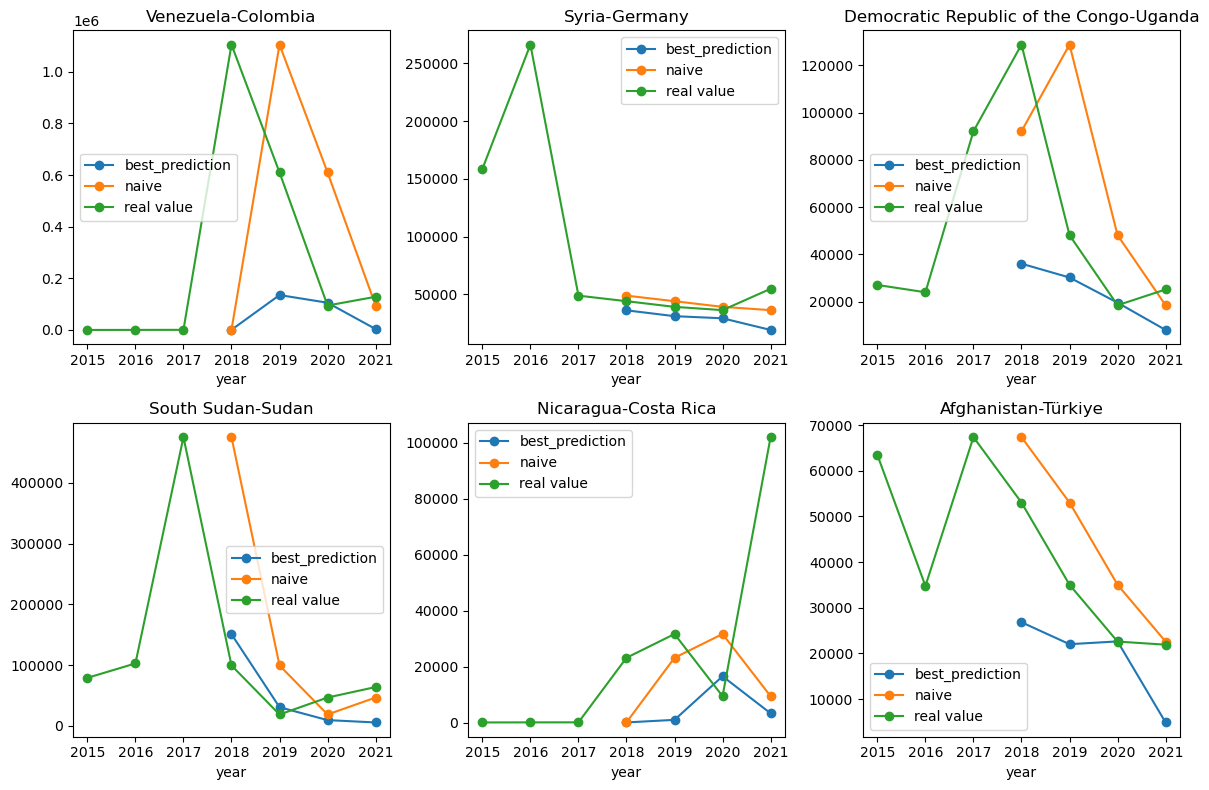

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(id, fullname, ax):
    pair = '\"' + id + '\"'
    pair_ = pair.strip('\"')
    dyad = y_preds_best.query("Id == {}".format(pair))
    dyad_unhcr = unhcr[['newarrival','newarrival_next_year','Id','year']].query('year >= 2014 & Id == {}'.format(pair))
    dyad_unhcr = dyad_unhcr.assign(year = dyad_unhcr.year + 1)

    dyad = dyad.assign(year = (dyad['year'] + 1)).merge(dyad_unhcr, on=['Id','year'], how='outer').sort_values('year').query('year <= 2021')
    dyad.loc[dyad.year <= 2017, 'newarrival'] = np.nan

    dyad.rename({'newarrival':'naive', 'newarrival_next_year':'real value', 'pred':'best_prediction'},axis=1).sort_values('year').set_index('year').plot.line(marker='o', title=fullname, ax=ax)
    
# Create a 2x3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot 1
plot_forecast('VENCOL', 'Venezuela-Colombia', axs[0, 0])

# Plot 2
plot_forecast('SYRDEU', 'Syria-Germany', axs[0, 1])

# Plot 3
plot_forecast('CODUGA', 'Democratic Republic of the Congo-Uganda', axs[0, 2])

# Plot 4
plot_forecast('SSDSDN', 'South Sudan-Sudan', axs[1, 0])

# Plot 5
plot_forecast('NICCRI', 'Nicaragua-Costa Rica', axs[1, 1])

# Plot 6
plot_forecast('AFGTUR', 'Afghanistan-Türkiye', axs[1, 2])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the grid of plots


In [168]:
results_df = y_preds_best.merge(unhcr[['Id','year','newarrival_next_year','newarrival']]).rename({'pred':'best_model', 'newarrival':'naive'}, axis=1)
results_df.loc[results_df['best_model'] < 0, 'pred'] = 0

In [172]:
# Compute RMSE for each row
results_df['naive_error'] = np.sqrt((results_df['newarrival_next_year'] - results_df['naive']) ** 2)
results_df['best_model_error'] = np.sqrt((results_df['newarrival_next_year'] - results_df['best_model']) ** 2)
# results_df['RF_outflow_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_outflow']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
results_df['actual_range'] = pd.cut(results_df['newarrival_next_year'], ranges, labels=labels, include_lowest=True)

In [183]:
# Compute mean RMSE for each group
grouped_errors = results_df[['naive_error', 'best_model_error','actual_range']].groupby('actual_range').mean()
grouped_errors = pd.concat([grouped_errors, results_df[['naive_error','actual_range']].groupby('actual_range').count().rename({'naive_error':'count'}, axis=1)], axis=1)

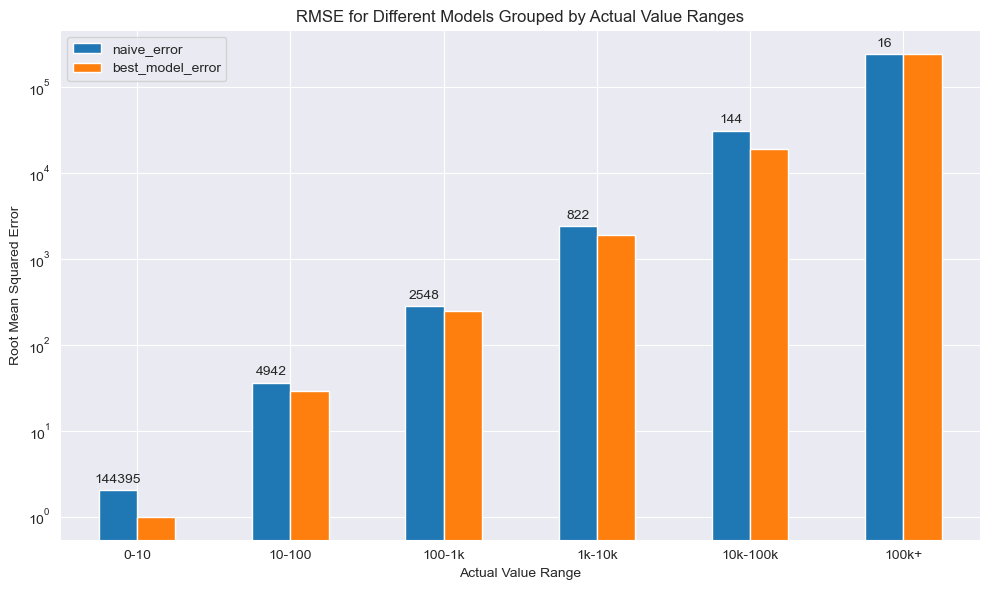

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

# Plot the bar plot
ax = grouped_errors[['naive_error','best_model_error']].plot(kind='bar', figsize=(10, 6))

# Add count values on top of each bar
for i, rect in enumerate(ax.patches):
    if i >= 6:
        continue
    height = rect.get_height()
    count = grouped_errors.iloc[i]['count'].astype(int).astype(str)
    ax.annotate(count, xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords='offset points', ha='center', va='bottom')

plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


<Axes: xlabel='pred', ylabel='newarrival_next_year'>

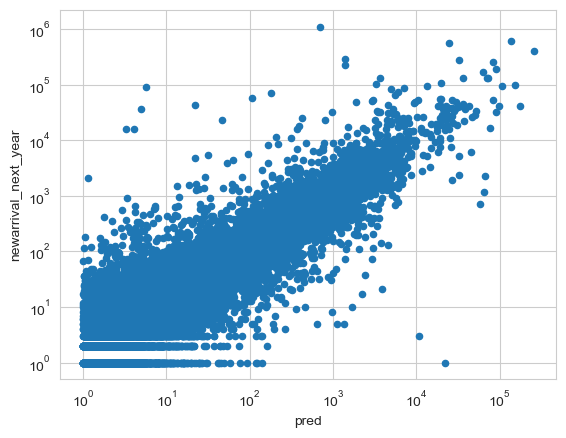

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
testt.plot.scatter(x='pred',y='newarrival_next_year', logx=True,logy=True) 

<Axes: xlabel='newarrival', ylabel='newarrival_next_year'>

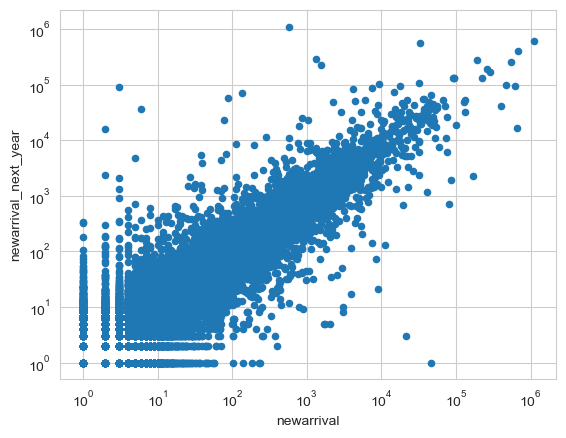

In [ ]:
testt.plot.scatter(x='newarrival',y='newarrival_next_year', logx=True,logy=True) 